<a href="https://colab.research.google.com/github/gg-hgew/courseera-test/blob/main/MUSIC%20GENRE%20ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'gtzan-dataset-music-genre-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F568973%2F1032238%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240909%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240909T062724Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db4c92b03f8b394aec0322279b1adf19ca634e5ef46aed2f08a982f3894aa5de2e0d890b24ff88c271746eee3e488f349d7fd3817c43e8556779994f3f170236fe6bb33d24939dd71cc9a8a6e857c57f076d1912e99ac6094327704e9a8e7d192482ee92610734c98a7939f2713003174445a6733f6c169aed425678c10b453353e32870801817a879f9287bde068f17d605cf7caa33f34f94d062afb4a1deac8dd046ead66be58d06221548db117c4dbac94756bd67c9e5a6af1e71eec16bed651303169aafd12c3a1aa2c79525cfefc4b38c24d5f9f718e9b16104388348fde1db9d02e2a6d75929b4e4baaf675eea019342d87e802755c72c49bfe98f7c214'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 1301492495 bytes downloaded
Downloaded and uncompressed: gtzan-dataset-music-genre-classification
Data source import complete.


IMPORT LIBRARY

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
import librosa, IPython
import librosa.display as lplt
seed = 12
np.random.seed(seed)

In [3]:
df = pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [4]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv')

# Display the number of rows and columns
num_rows, num_cols = df.shape
print(f'Number of datasets (rows): {num_rows}')
print(f'Number of input columns (features): {num_cols}')

# Display the names of the input columns
print('Input columns:')
print(df.columns.tolist())

# Display the statistical summary for each column
print('\nStatistical Summary:')
print(df.describe(include='all'))


Number of datasets (rows): 9990
Number of input columns (features): 60
Input columns:
['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo', 'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var', 'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var', 'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var', 'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean', 'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var', 'label

visualise data set

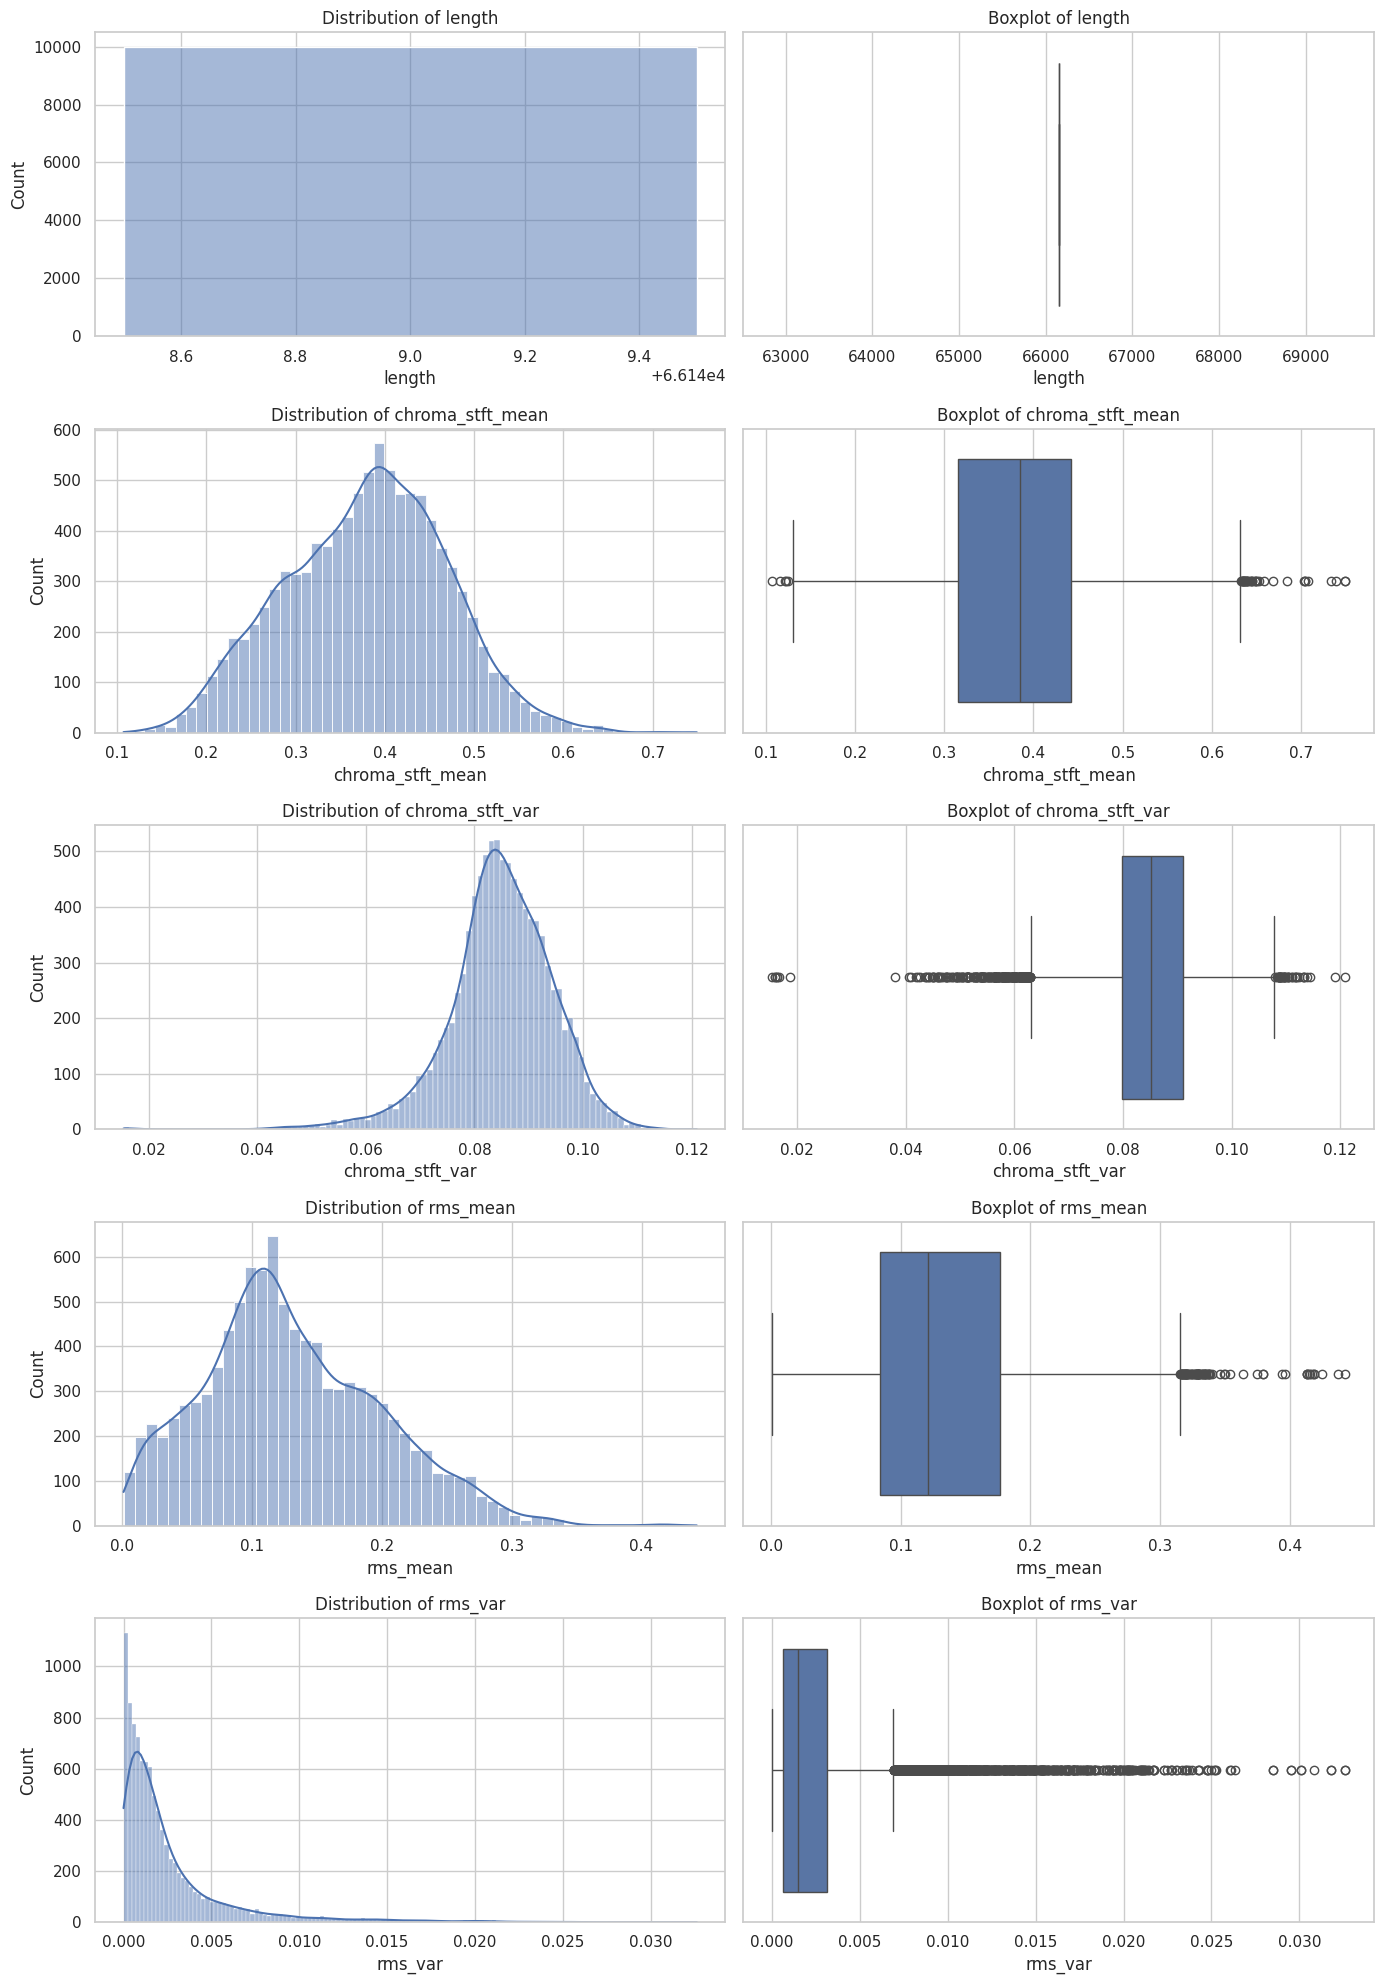

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv')

# Set the style of seaborn
sns.set(style="whitegrid")

# Select a subset of numerical features (e.g., the first 5)
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns[:5]

# Visualize the distribution of these features
def plot_subset_feature_distribution(df, features):
    plt.figure(figsize=(14, len(features) * 4))

    for i, feature in enumerate(features):
        plt.subplot(len(features), 2, i * 2 + 1)
        sns.histplot(df[feature], kde=True)
        plt.title(f'Distribution of {feature}')

        plt.subplot(len(features), 2, i * 2 + 2)
        sns.boxplot(x=df[feature])
        plt.title(f'Boxplot of {feature}')

    plt.tight_layout()
    plt.show()

plot_subset_feature_distribution(df, numerical_features)


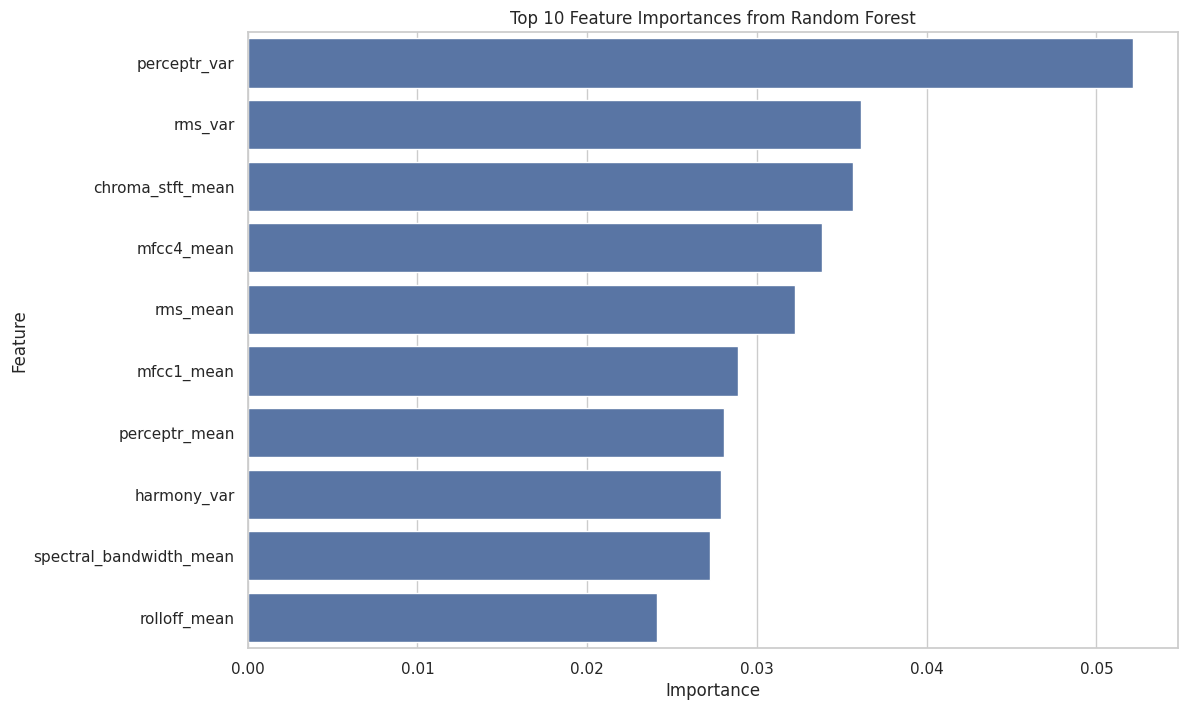

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Encode the genre labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

# Separate features and target
X = df.drop(columns=['filename', 'label'])
y = df['label']

# Initialize and fit the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=seed)
model.fit(X, y)

# Get feature importances and select the top 10 features
importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 10 Feature Importances from Random Forest')
plt.show()


In [9]:
audio_fp = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00000.wav'
audio_data, sr = librosa.load(audio_fp)
audio_data, _ = librosa.effects.trim(audio_data)

In [10]:
# play sample file
IPython.display.Audio(audio_data, rate=sr)

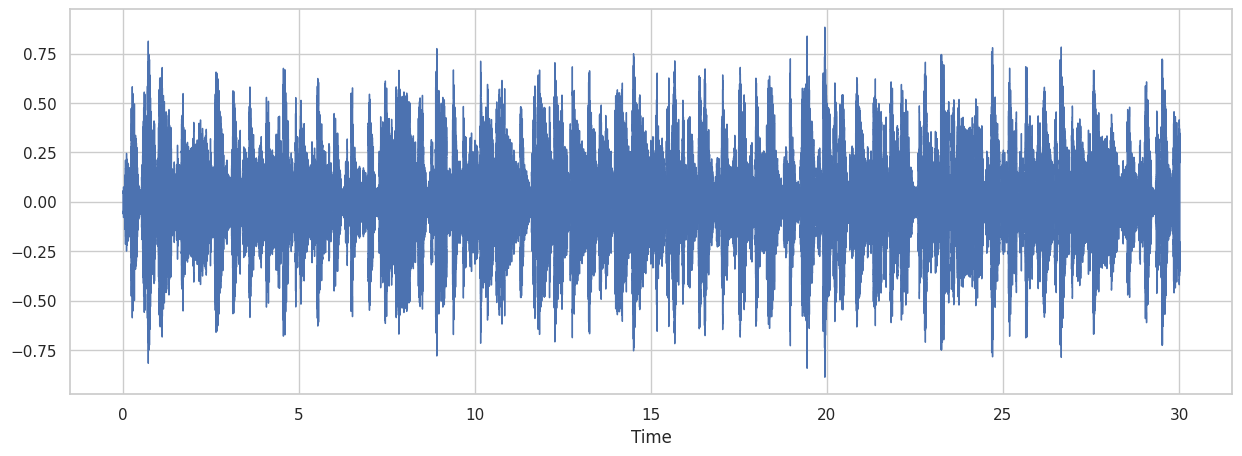

In [12]:
# plot sample file
plt.figure(figsize=(15,5))
librosa.display.waveshow(audio_data) # Use waveshow instead of waveplot
plt.show()

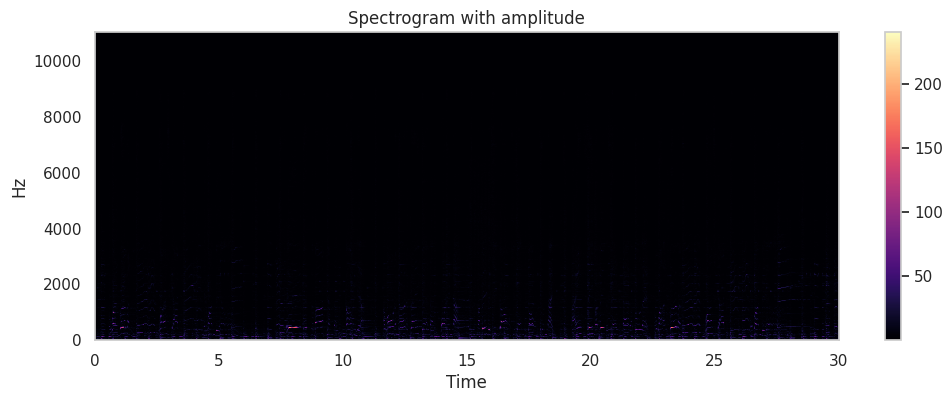

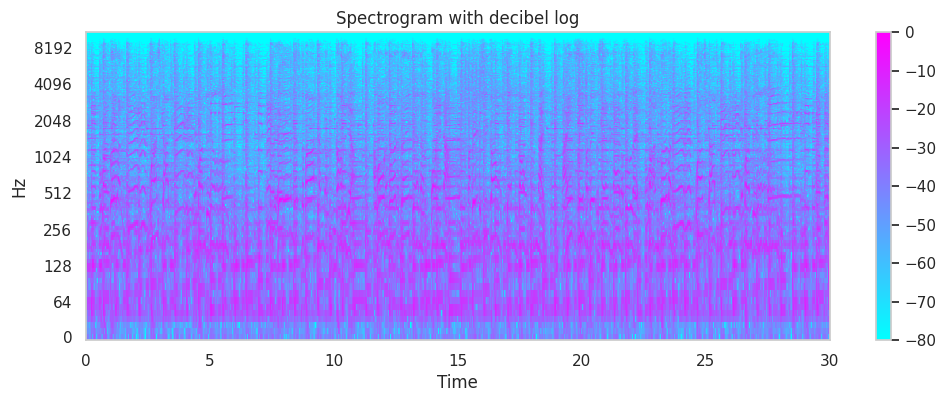

In [13]:
# Default FFT window size
n_fft = 2048 # window size
hop_length = 512 # window hop length for STFT

stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(stft, ref=np.max)

plt.figure(figsize=(12,4))
lplt.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram with amplitude")
plt.show()

plt.figure(figsize=(12,4))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()

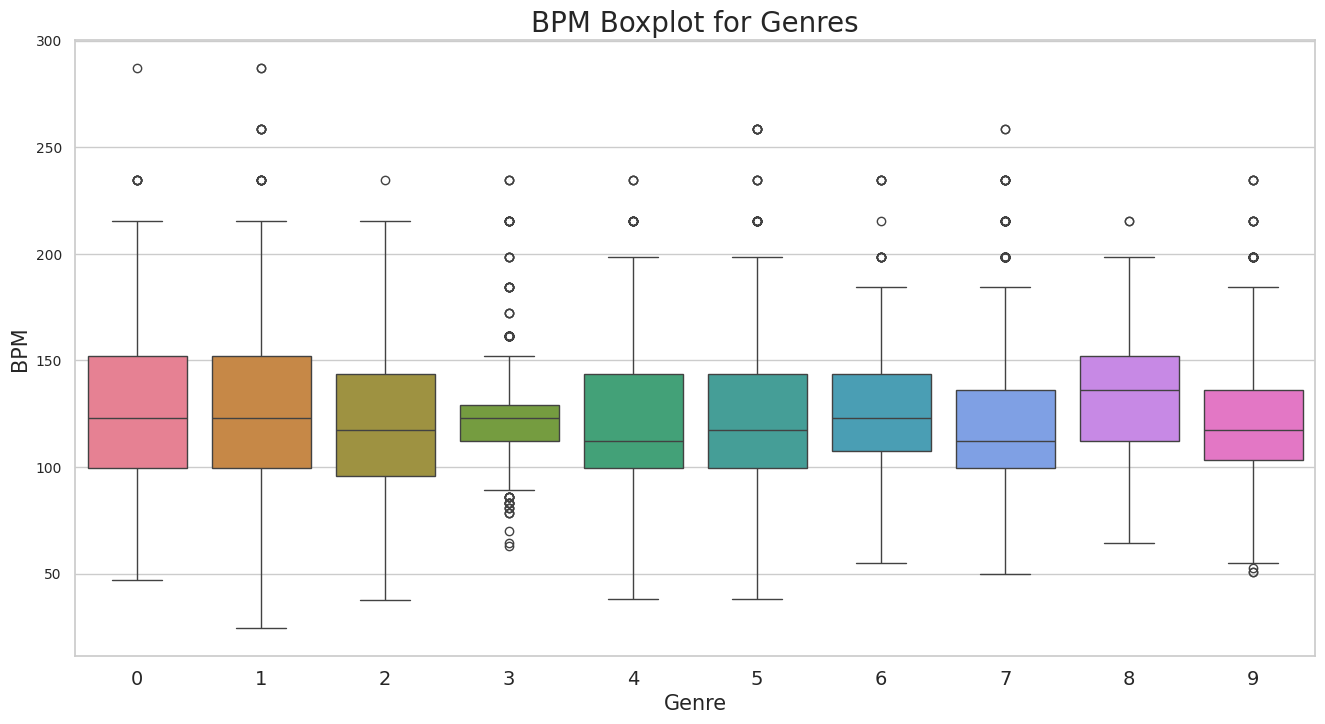

In [14]:
x = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM_Boxplot.png")

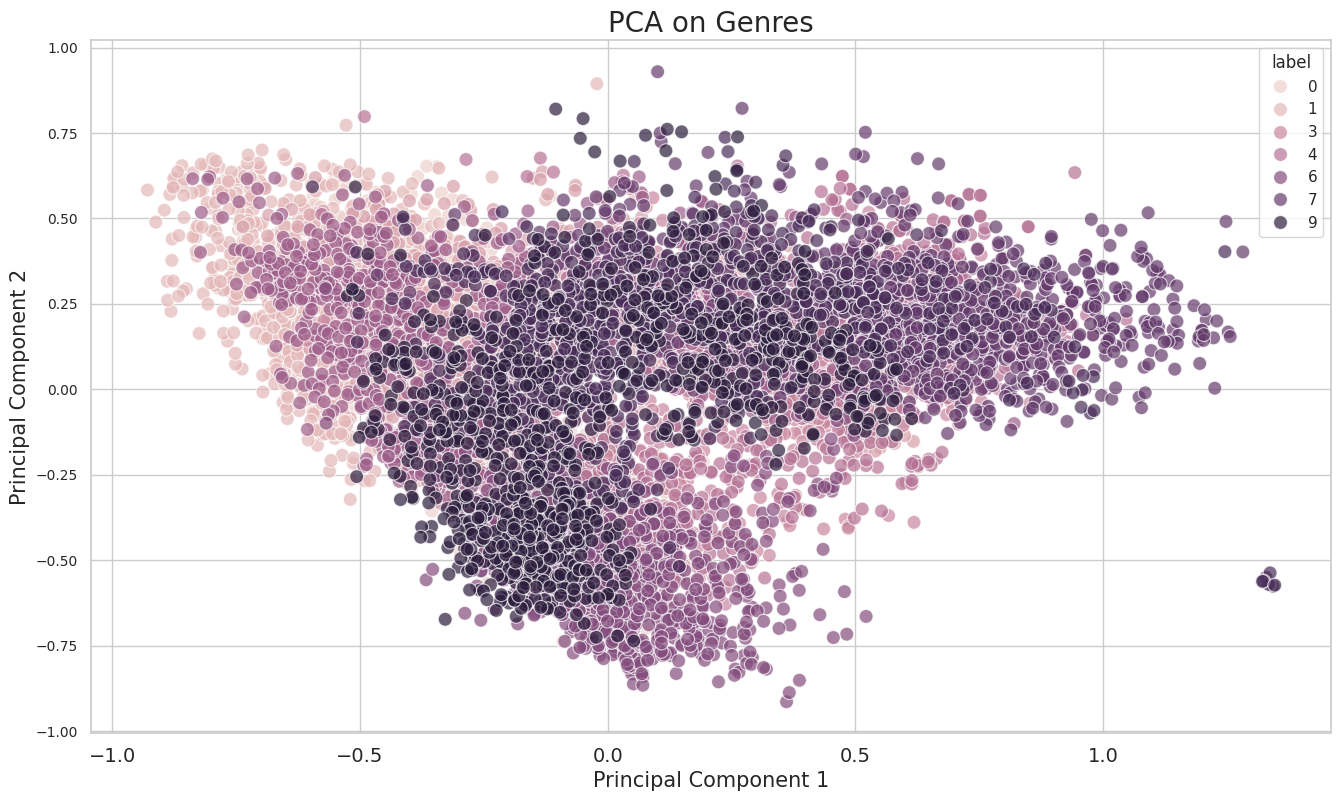

In [15]:
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# normalize
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

# Top 2 pca components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

plt.figure(figsize = (16, 9))
sns.scatterplot(x = "pc1", y = "pc2", data = finalDf, hue = "label", alpha = 0.7, s = 100);

plt.title('PCA on Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA_Scattert.png")

In [17]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Calculate mean and variance for numeric columns
mean_features = numeric_df.mean()
variance_features = numeric_df.var()

# Print the results
print("Mean of each feature:")
print(mean_features)

print("\nVariance of each feature:")
print(variance_features)


Mean of each feature:
length                     6.614900e+04
chroma_stft_mean           3.795341e-01
chroma_stft_var            8.487615e-02
rms_mean                   1.308591e-01
rms_var                    2.676388e-03
spectral_centroid_mean     2.199219e+03
spectral_centroid_var      4.166727e+05
spectral_bandwidth_mean    2.241386e+03
spectral_bandwidth_var     1.182711e+05
rolloff_mean               4.566077e+03
rolloff_var                1.628790e+06
zero_crossing_rate_mean    1.025785e-01
zero_crossing_rate_var     2.620121e-03
harmony_mean              -3.646305e-04
harmony_var                1.259757e-02
perceptr_mean             -3.955016e-04
perceptr_var               5.601553e-03
tempo                      1.248877e+02
mfcc1_mean                -1.454246e+02
mfcc1_var                  2.808904e+03
mfcc2_mean                 1.009882e+02
mfcc2_var                  5.887954e+02
mfcc3_mean                -9.995014e+00
mfcc3_var                  3.741376e+02
mfcc4_mean        

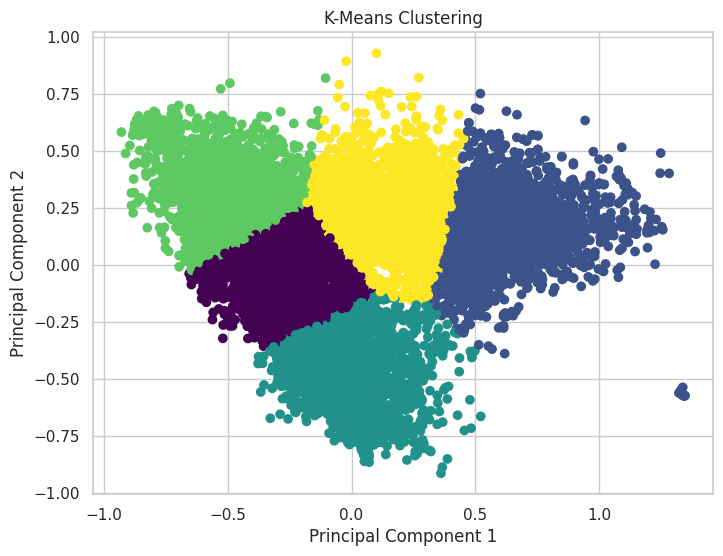

In [21]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(pca_result)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


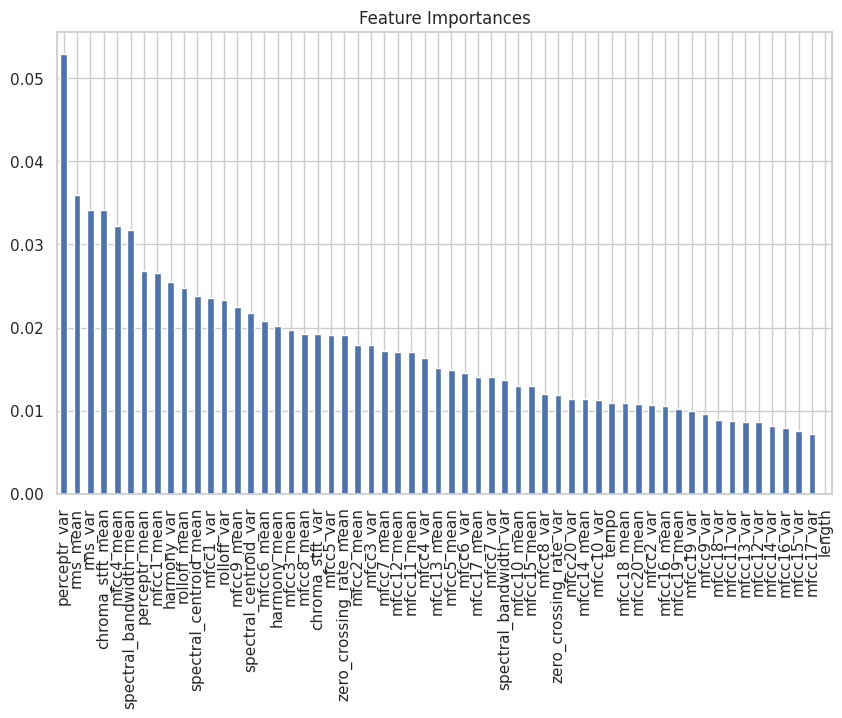

In [22]:
if 'label' in df.columns:
    X = numeric_df.drop(columns=['label'])
    y = df['label']

    rf = RandomForestClassifier()
    rf.fit(X, y)
    importances = rf.feature_importances_

    # Plot feature importances
    feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    feature_importances.plot(kind='bar')
    plt.title('Feature Importances')
    plt.show()


In [23]:
if 'label' in df.columns:
    numeric_df = df.select_dtypes(include=[np.number])
    label_correlation = numeric_df.corr()['label'].sort_values()
    print("\nCorrelation with Labels:")
    print(label_correlation)



Correlation with Labels:
mfcc2_mean                -0.348035
mfcc20_var                -0.099627
mfcc12_var                -0.090699
mfcc13_var                -0.089063
chroma_stft_var           -0.079683
mfcc14_var                -0.068083
mfcc15_var                -0.067919
mfcc19_var                -0.059141
perceptr_mean             -0.053023
harmony_mean              -0.050513
mfcc11_var                -0.049489
mfcc4_mean                -0.048384
mfcc16_var                -0.044354
mfcc17_var                -0.040047
mfcc18_var                -0.039150
mfcc17_mean                0.004921
tempo                      0.012369
mfcc19_mean                0.013143
mfcc10_var                 0.021395
mfcc16_mean                0.026503
mfcc6_mean                 0.039947
mfcc9_var                  0.041014
mfcc14_mean                0.051521
mfcc5_var                  0.051668
mfcc1_var                  0.059184
mfcc15_mean                0.065622
mfcc13_mean                0.066110
mf